In [1]:
#update.packages(ask = FALSE)

In [2]:
library("IBMPopSim")
library("ggplot2")
library("Rcpp")
library(dplyr)
library(gridExtra)
library(ggExtra)


Attaching package: ‘IBMPopSim’


The following object is masked from ‘package:stats’:

    stepfun



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




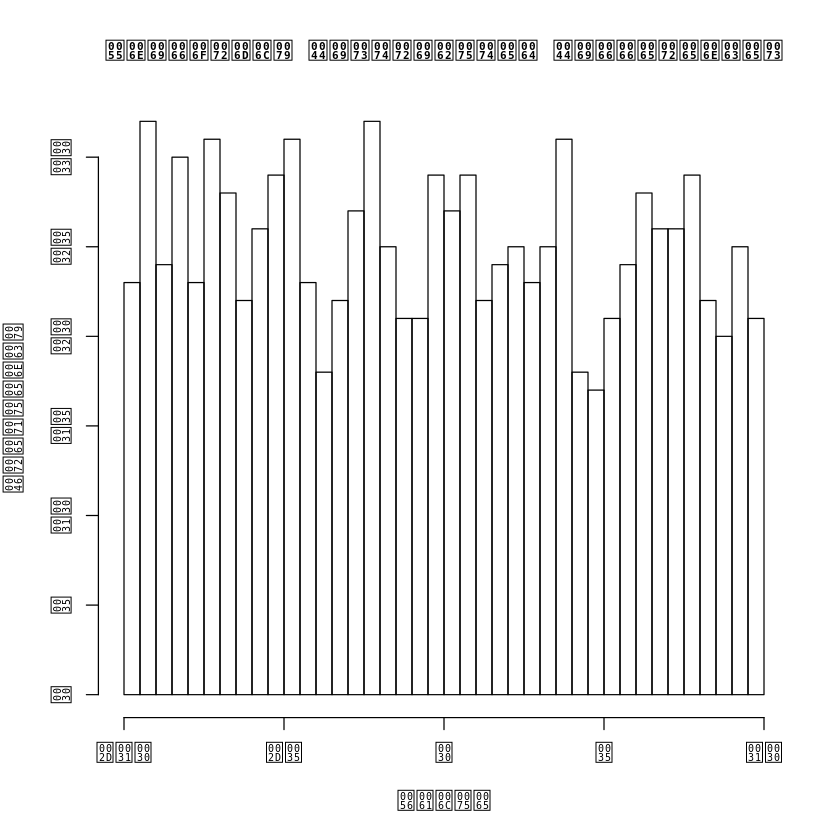

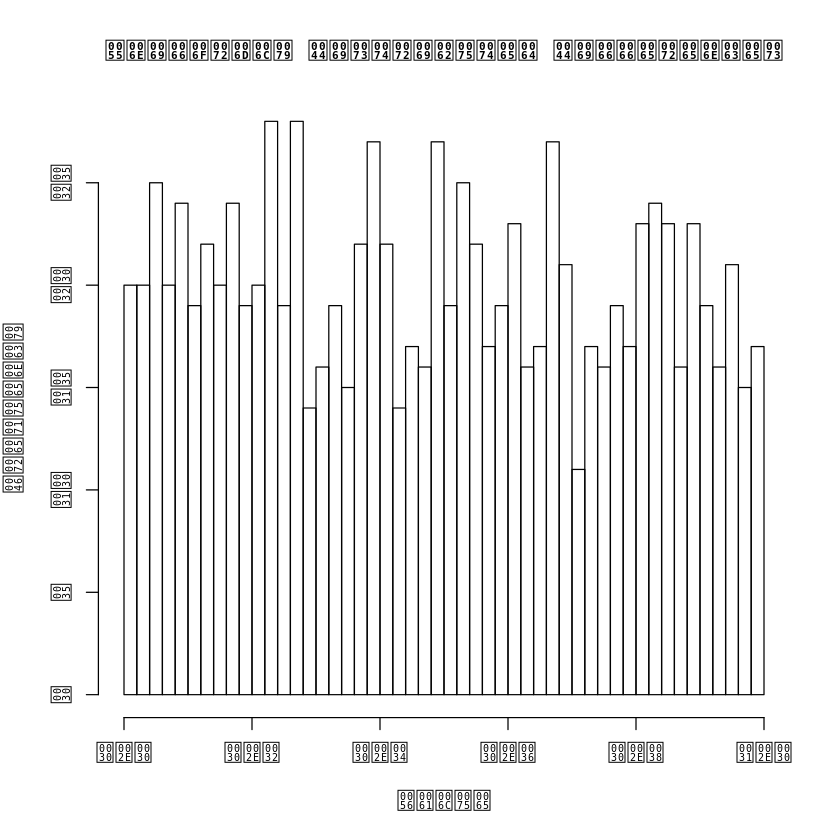

In [12]:
# Number of random numbers to generate
n <- 1000

# Generate uniform random numbers between 0 and 1
random_nums <- runif(n)

# Scale and shift to interval [-10, 10]
random_diffs <- (random_nums * 20) - 10
hist(random_diffs, main = "Uniformly Distributed Differences", xlab = "Value", ylab = "Frequency", breaks = 40)

hist(random_nums, main = "Uniformly Distributed Differences", xlab = "Value", ylab = "Frequency", breaks = 40)


In [13]:
# Generate initial population
N <- 10000  # Number of individuals in the initial population

In [40]:
# xb - xd is distributed uniformly on -10 ,10
#xd <- runif(N,0,10)
pop_init <- data.frame(
  "birth" = rep(0,N), 
  "death" = as.double(NA),
  "Lansing" = rep(c(FALSE,FALSE),N/2),
    "ib"=1,
    "i_d"=1,
#    "xb"= 10-xd, 
#    "xd" =  xd, 
    "xb" = 1.5,
    "xd" = 1,
    "lignee"=1:N
)
get_characteristics(pop_init)


Lansing       ib      i_d       xb       xd   lignee 
  "bool" "double" "double" "double" "double"    "int"

In [41]:
head(pop_init)
#plot.ecdf(pop_init$xb-pop_init$xd)

birth death Lansing ib i_d xb  xd lignee
1 0     NA    FALSE   1  1   1.5 1  1     
2 0     NA    FALSE   1  1   1.5 1  2     
3 0     NA    FALSE   1  1   1.5 1  3     
4 0     NA    FALSE   1  1   1.5 1  4     
5 0     NA    FALSE   1  1   1.5 1  5     
6 0     NA    FALSE   1  1   1.5 1  6

In [42]:
# Events and model creation
 # There are 2 possible events :

# - Birth (with or without mutation)
# - Death

# Each event is characterized by its intensity and  kernel code, described below.

## Birth event with individual intensity

### Parameters



In [43]:
params_birth <- list("p"=0.1 , "var_mut"=0.05)

In [44]:
birth_event <- mk_event_individual( type = "birth",
  intensity_code = ' if (age(I,t) < I.xb)
                        result = I.ib; 
                    else 
                        result =0;',  # each individual  I can give birth at rate ib if its age is less than xb
  kernel_code = 'if (CUnif() < p){
                     newI.xb = max(0., CNorm(I.xb, var_mut));
                     newI.ib = max(0., CNorm(I.ib, var_mut));
                     newI.i_d = max(0., CNorm(I.i_d, var_mut));}
                 else{
                     newI.xb = I.xb;
                     newI.ib = I.ib;
                     newI.i_d = I.i_d;}
                if (I.Lansing & (age(I,t)> I.xd) & (age(I,t)<I.xb))
                     newI.xd =0;
                 else{
                    if (CUnif()<p)
                        newI.xd =max(0., CNorm(I.xd, var_mut));
                     else 
                        newI.xd =I.xd;}
                 newI.Lansing =I.Lansing;
                 newI.lignee =I.lignee;') 
# An individual I can give birth to an individual newI. The kernel code defines characteristics of individual newI
# Attention la manière dont est calculée le trait après mutation est un peu différente du code du Tristan

In [45]:
## Death event 
### parameters
params_death <- list("compet"= 0.0009)

In [46]:
## Deaths due to interactions
death_event1 <- mk_event_interaction(name='death1',
  type = "death",
  interaction_code = "result = compet;" 
)

In [47]:
## Deaths due to aging 
death_event2 <- mk_event_individual(name='death2', type="death",
                  intensity_code = ' if (age(I,t)>I.xd) result= I.i_d; 
                                     else result =0;')

In [48]:
# Model creation 
model <- mk_model(
  characteristics = get_characteristics(pop_init),
  events = list(birth_event, death_event1, death_event2),
  parameters = c(params_birth, params_death)

)
summary(model)

Events:
#1: individual event of type birth
#2: interaction event of type death
#3: individual event of type death
--------------------------------------- 
Individual description:
names:  birth death Lansing ib i_d xb xd lignee 
R types:  double double logical double double double double integer 
C types:  double double bool double double double double int
--------------------------------------- 
R parameters available in C++ code:
names:  p var_mut compet 
R types:  double double double 
C types:  double double double

In [49]:
## Bounds for birth and death rates 
birth_intensity_max <- 10
interaction_fun_max <- params_death$compet
death2_max <- 10

In [50]:
T = 100 # Simulation end time 

sim_out <- popsim(model = model,
  population = pop_init,
  events_bounds = c('birth'=birth_intensity_max, 'death1'=interaction_fun_max,'death2'= death2_max),
  parameters = c(params_birth, params_death),
  time = T)

Simulation on  [0, 100] 

In [51]:
# Simulation with different parameters

#The model can be simulated with different parameters without being recompiled.


In [52]:
#sim_out$logs["duration_main_algorithm"]
#sim_out$logs

In [53]:
# Outputs

In [54]:
str(sim_out$population)

'data.frame':	366476 obs. of  8 variables:
 $ birth  : num  97.5 97.7 98 98.1 98.2 ...
 $ death  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Lansing: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ ib     : num  2.84 3.08 2.78 2.96 2.96 ...
 $ i_d    : num  1.199 1.172 0.983 1.187 1.066 ...
 $ xb     : num  1.69 1.44 1.41 1.59 1.66 ...
 $ xd     : num  0.797 0.953 0.984 0.798 0.976 ...
 $ lignee : int  8585 8585 8585 8585 8585 8585 8585 8585 8585 8585 ...


In [55]:
pop_out <- sim_out$population
head(pop_out)
tail(pop_out)

birth    death Lansing ib       i_d       xb       xd        lignee
1 97.52551 NA    FALSE   2.844389 1.1986414 1.691306 0.7965458 8585  
2 97.71504 NA    FALSE   3.083583 1.1717934 1.442515 0.9533324 8585  
3 97.98589 NA    FALSE   2.779219 0.9830282 1.408452 0.9841816 8585  
4 98.06736 NA    FALSE   2.957679 1.1874740 1.589888 0.7978397 8585  
5 98.19201 NA    FALSE   2.955261 1.0660504 1.661361 0.9756867 8585  
6 98.24328 NA    FALSE   2.954367 1.1573340 1.566158 0.8092574 8585

birth    death    Lansing ib       i_d       xb       xd        lignee
366471 99.96879 99.99879 FALSE   3.002807 0.8866430 1.262427 1.0848178 8585  
366472 99.98086 99.98645 FALSE   2.853288 1.1549259 1.675295 0.9041318 8585  
366473 99.98189 99.99394 FALSE   3.103187 1.1573351 1.675034 1.2354457 8585  
366474 99.98221 99.99880 FALSE   3.010874 1.1510761 1.916129 0.9232136 8585  
366475 99.98390 99.98839 FALSE   2.961601 0.8006014 1.082665 1.0397238 8585  
366476 99.99388 99.99964 FALSE   2.955500 1.2617718 1.567997 0.9455430 8585

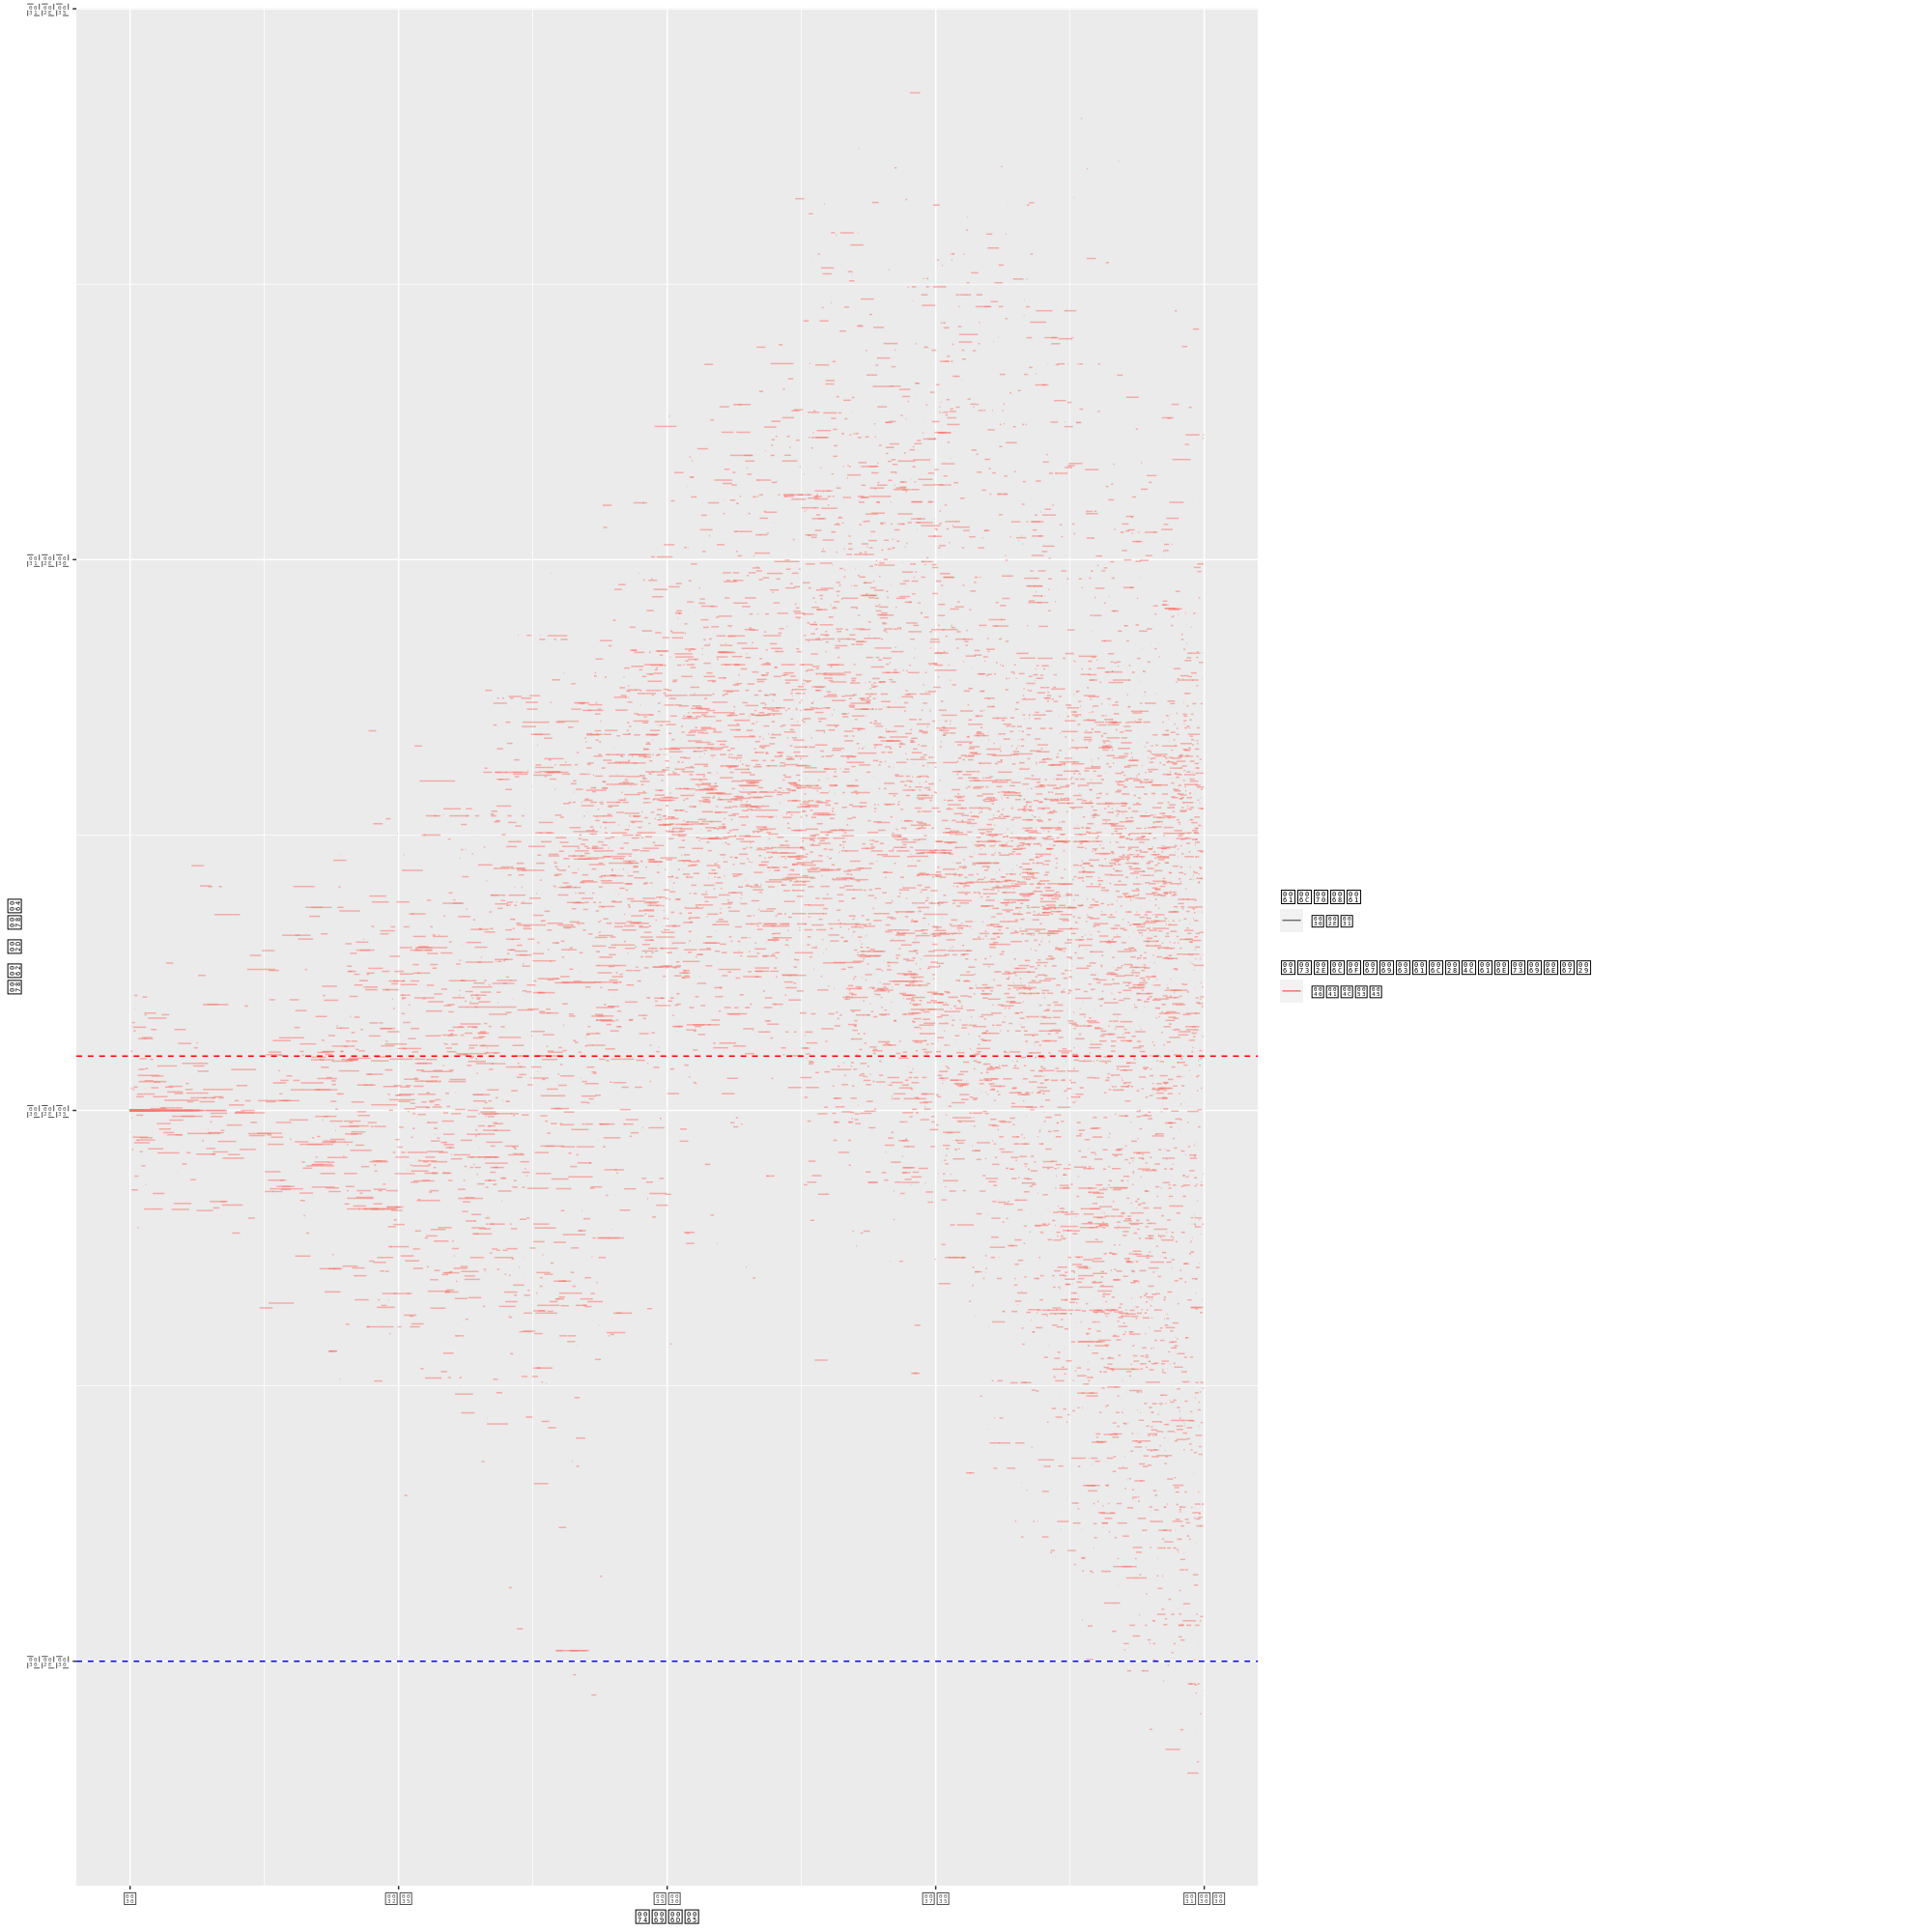

In [56]:
#options(repr.plot.width=15, repr.plot.height=15)
xbxd_evol_for_publi <- ggplot(pop_out %>% sample_n(10000), aes(color=as.logical(Lansing), alpha = 0.1)) + 
  geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.1) , na.rm=TRUE)+
  xlab("Time") +
  ylab("xb-xd") + 
  geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
  geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
  labs(x='time',y='xb - xd')

xbxd_evol_for_publi

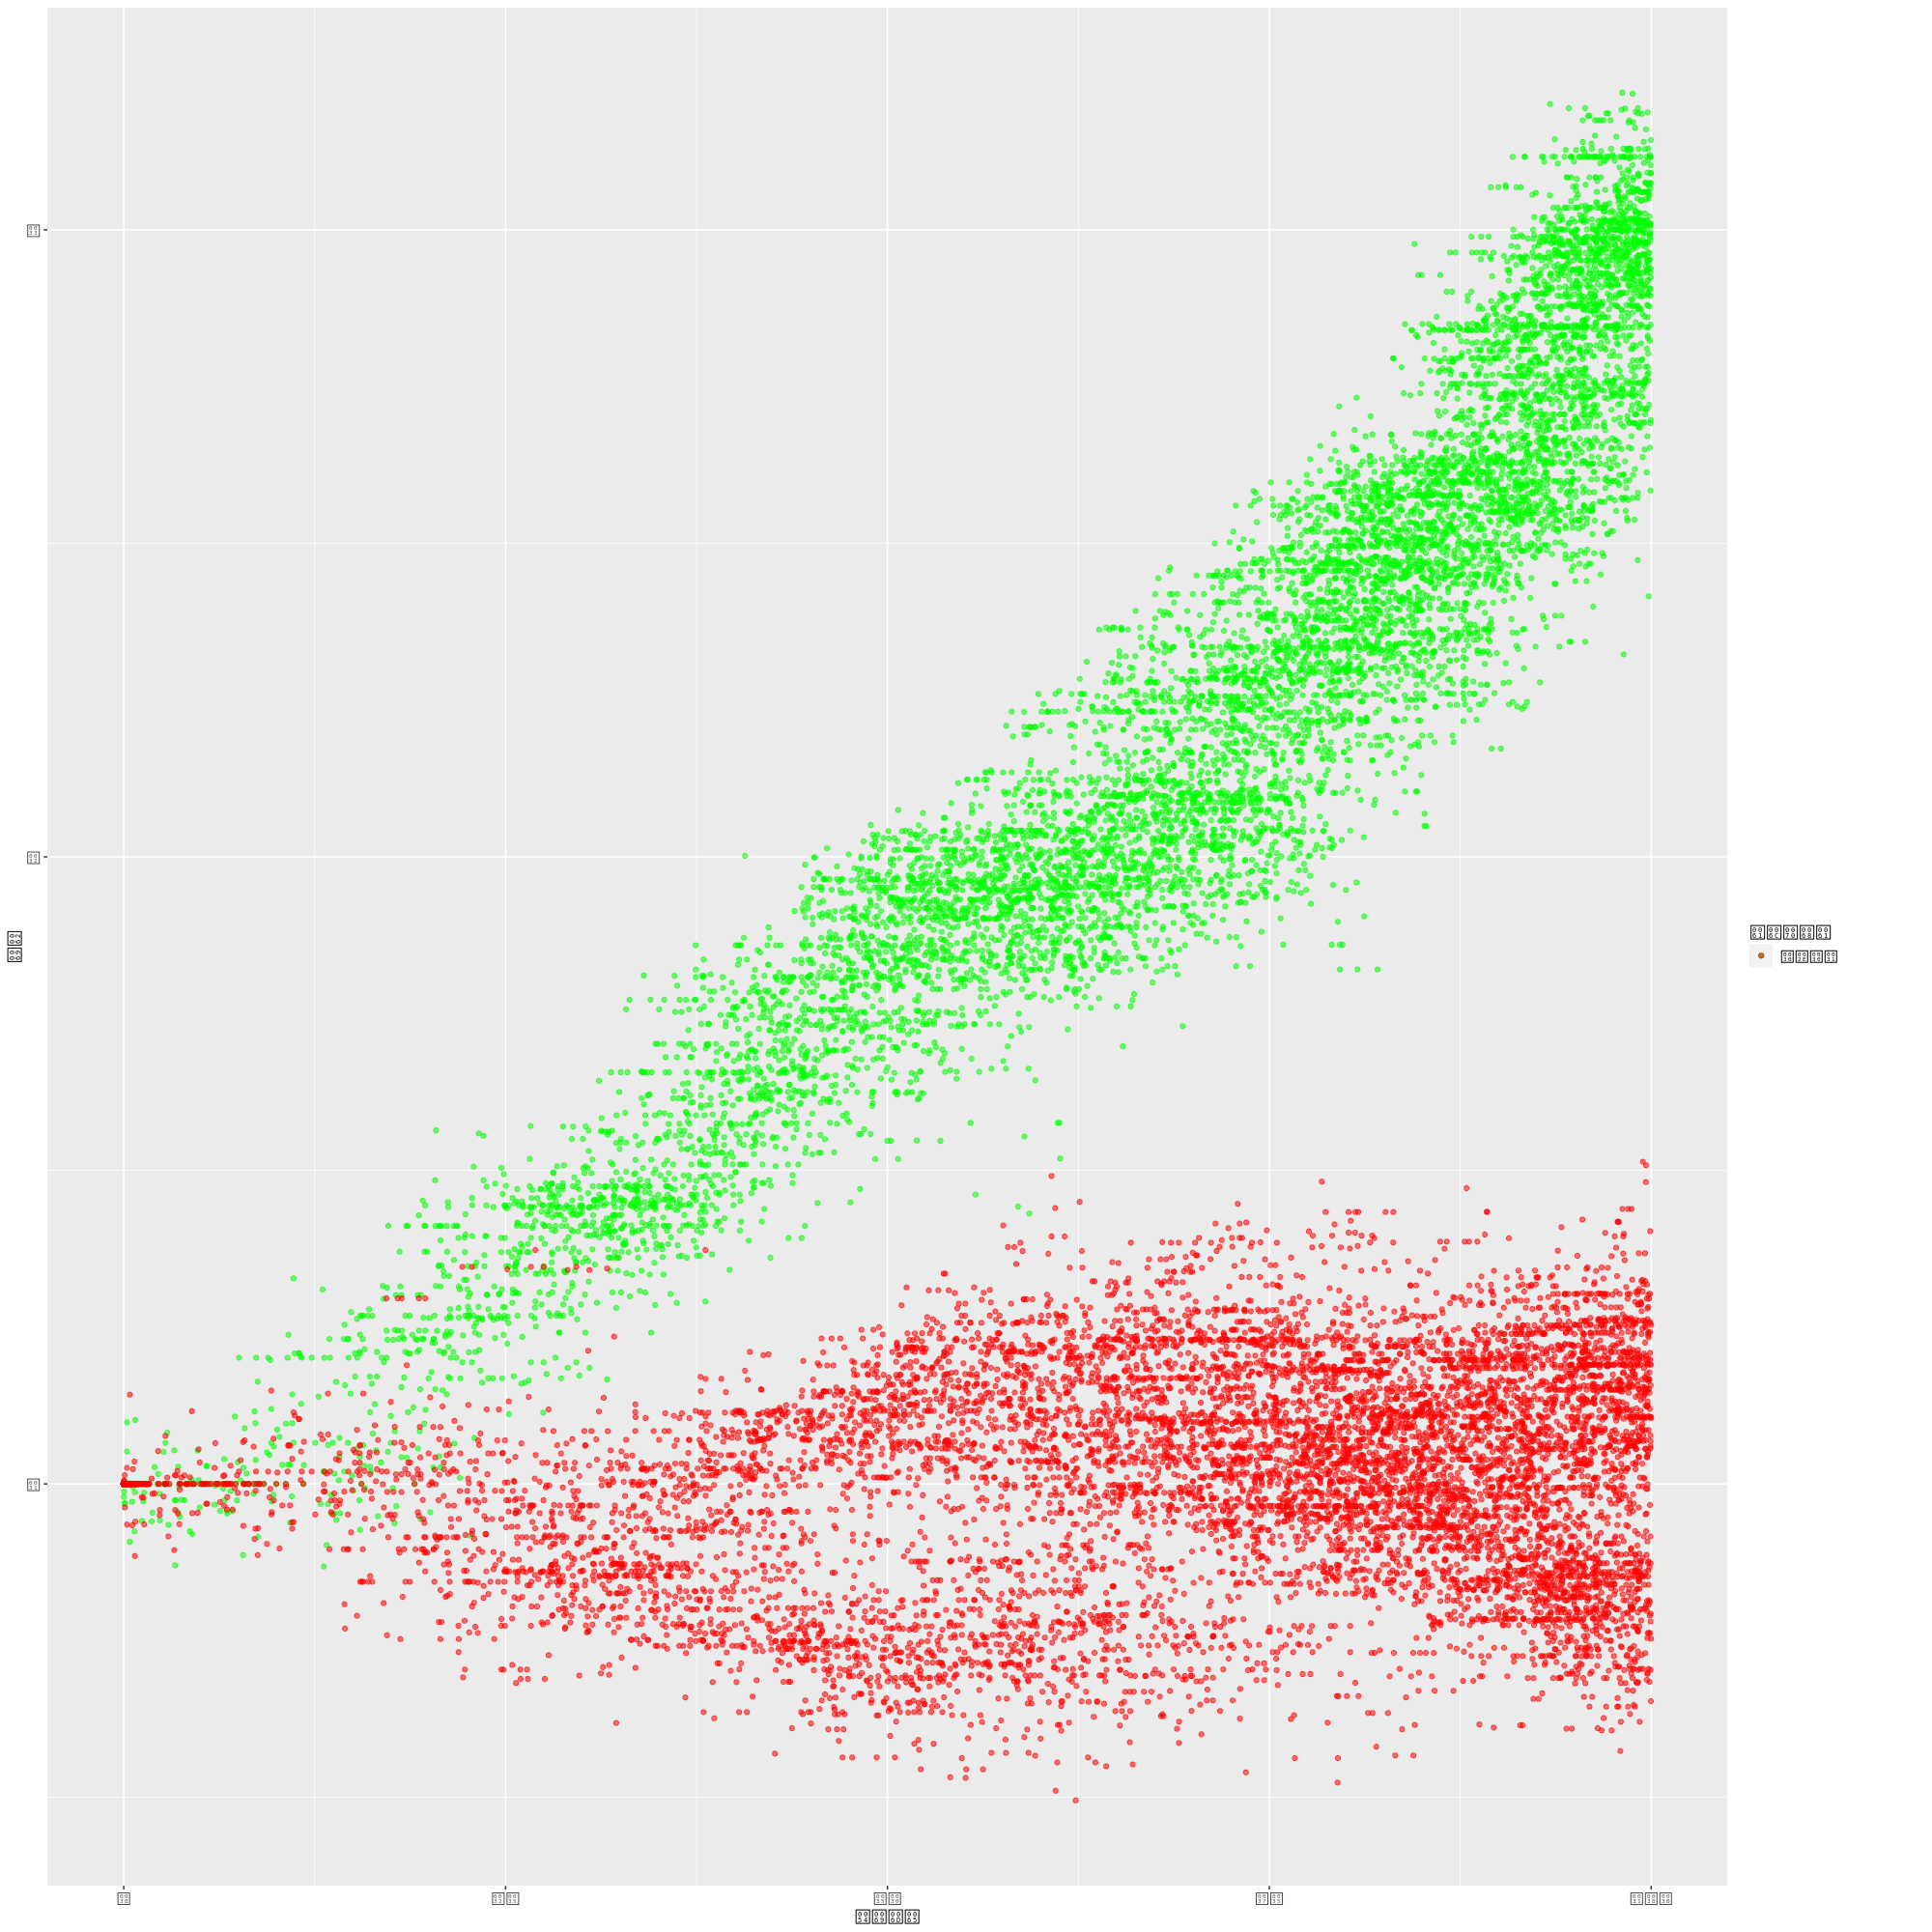

In [57]:
#options(repr.plot.width=15, repr.plot.height=15)
ibid_evol_for_publi <- ggplot(pop_out %>% sample_n(10000), aes(x=birth)) + 
  geom_point(aes(y=ib, alpha = 0.01) , na.rm=TRUE, colour='green')+
  geom_point(aes(y=i_d, alpha = 0.01) , na.rm=TRUE, colour='red')+
  xlab("Time") 
  #ylab("xb-xd") + 
  #theme(legend.position="none")+
  #theme(axis.text=element_text(size=12),
  #      axis.title=element_text(size=14,face="bold"))

ibid_evol_for_publi

In [58]:
# Create a sampled dataset 
sample_data <- pop_out %>% sample_n(10000)

# Generate the ggplot
p0 <- ggplot(sample_data, aes(x = birth, alpha = 0.1)) + 
  geom_point(aes(y = ib, color = 'IB'), na.rm = TRUE) +
  geom_point(aes(y = i_d, color = 'ID'), na.rm = TRUE) +
  scale_color_manual(
    name = "Groups",
    values = c("IB" = "green", "ID" = "red")
  ) +
  scale_alpha(guide = 'none') +  # Hide alpha legend
  labs(
    x = "Time",
    y = "Value",
    title = "Your Plot Title",
    subtitle = "Your Plot Subtitle",
    caption = "Your Caption"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "bottom",
    panel.grid.major = element_line(color = "grey90")
  )

p0_ <- ggplot(sample_data, aes(x = birth, alpha = 0.1)) + 
  geom_point(aes(y = xb, color = 'IB'), na.rm = TRUE) +
  geom_point(aes(y = xd, color = 'ID'), na.rm = TRUE) +
  scale_color_manual(
    name = "Groups",
    values = c("IB" = "green", "ID" = "red")
  ) +
  scale_alpha(guide = 'none') +  # Hide alpha legend
  labs(
    x = "Time",
    y = "Value",
    title = "Your Plot Title",
    subtitle = "Your Plot Subtitle",
    caption = "Your Caption"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "bottom",
    panel.grid.major = element_line(color = "grey90")
  )

In [59]:
#options(repr.plot.width=15, repr.plot.height=15)
p1<-ggplot(pop_out %>% sample_n(10000)) + 
  geom_point(aes(x=xb,y=ib, alpha = 0.01, colour=birth))+ theme(legend.position = "none") 
p1<-ggMarginal(p1,type = "histogram", xparams = list(binwidth = 0.1)) 
p2<-ggplot(pop_out %>% sample_n(10000)) + 
  geom_point(aes(x=xd,y=i_d, alpha = 0.01, colour=birth))+ theme(legend.position = "none") 
p2<-ggMarginal(p2,type = "histogram", xparams = list(binwidth = 0.1))

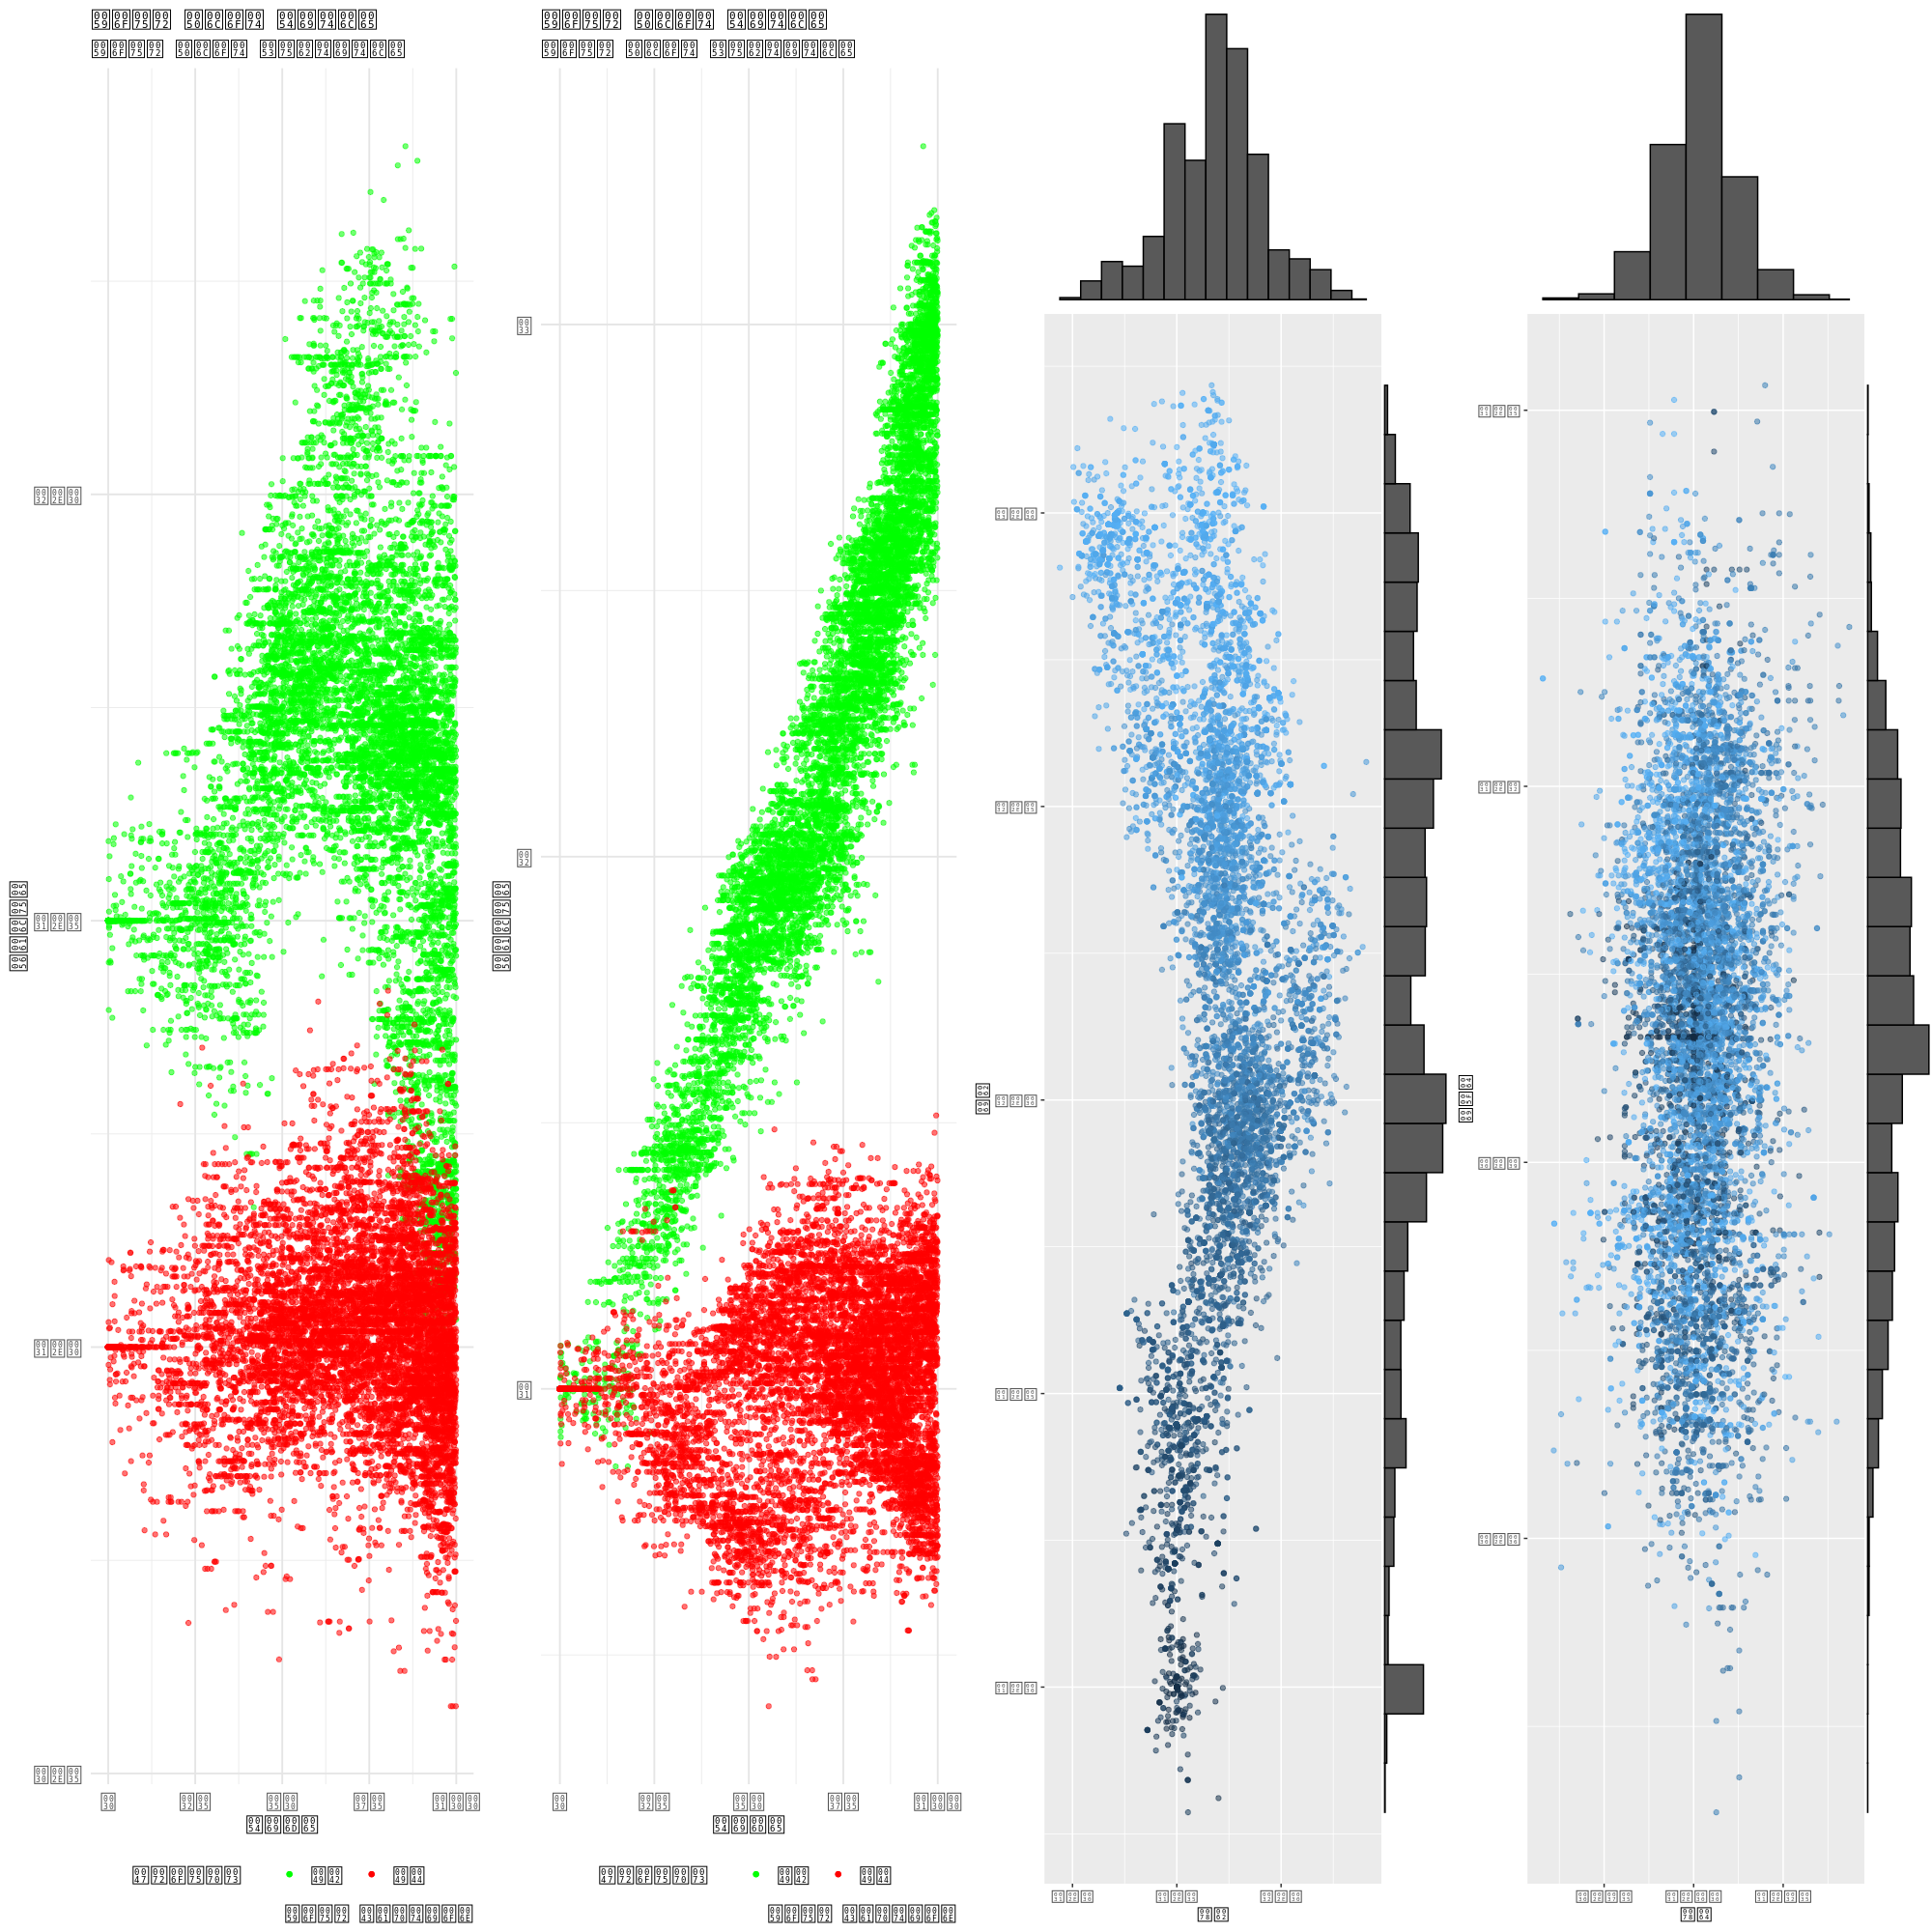

In [60]:
grid.arrange(p0_, p0, p1, p2, ncol=4)

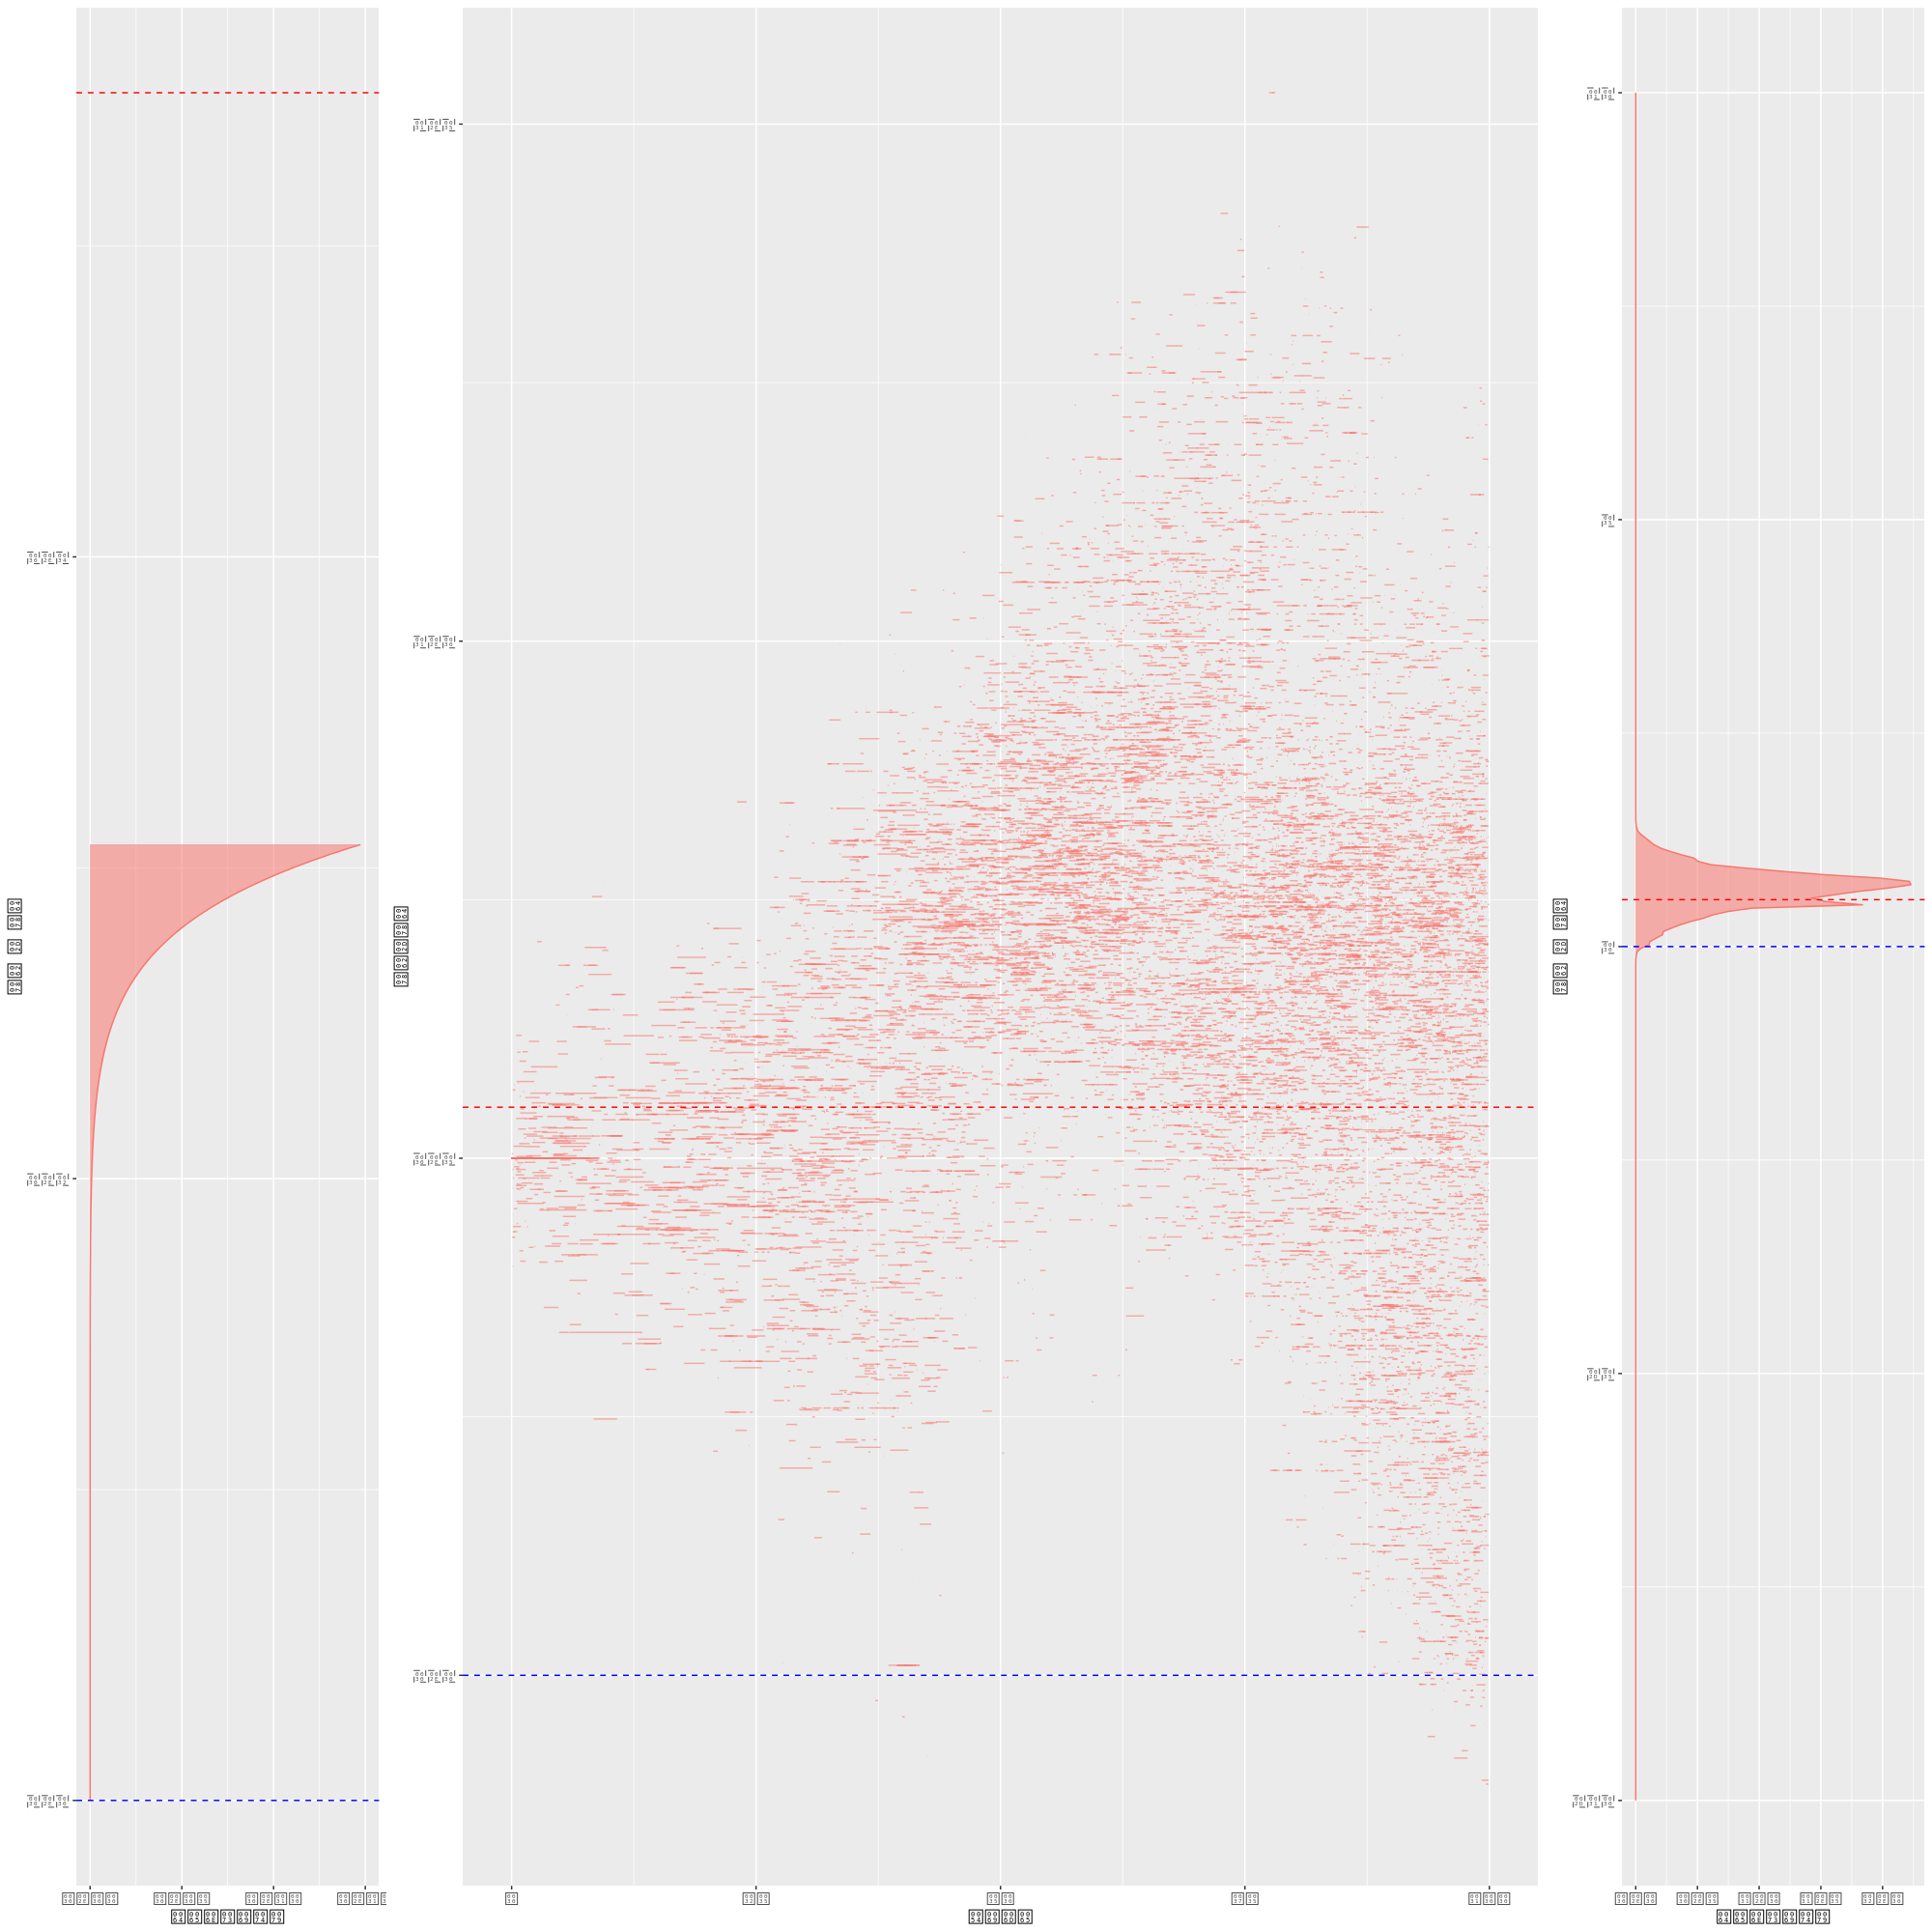

In [61]:
t0density <-  ggplot(pop_out %>% filter(birth==0), aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.1)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                ylim(0,0.15) + 
                coord_flip() +
                theme(legend.position="none")

soldensity <- ggplot(pop_out, aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.1)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                coord_flip() +
                xlim(-10,10) +
                theme(legend.position="none")

xbxd_evol <- ggplot(pop_out  %>% sample_n(20000), aes(color=as.logical(Lansing))) + 
                geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.5) , na.rm=TRUE)+
                xlab("Time") +
                ylab("xb-xd") + 
                geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
                geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
                theme(legend.position="none")

p = grid.arrange(t0density, xbxd_evol, soldensity, ncol=3, nrow = 1, widths=c(2,6,2))

In [62]:
#calculation of Malthusian parameters (Newton's method)
deriv_2 <- function(f, x, y, dx){
  return((f(x+dx, y)-f(x, y))/dx)
}
deriv_3 <- function(f, x, y, z, dx){
  return((f(x+dx, y, z)-f(x, y, z))/dx)
}
F <- function(a, b){
  u = 0
  if(a == 0){u = b - 1}
  else{u = ((1/a)*(1-exp(-a*b)))-1}
  return(u)
}
H <- function(a, b, d){
  u = 0
  if(a == 0){ u = d - exp(d-b)}
  else{u = ((1-exp(-a*d))/a) + (exp(d)/(1+a))*(exp(-d*(1+a))-exp(-b*(1+a)))-1}
  return(u)
}
G <- function(a, d){
  u = 0
  if(a == 0){u = d - 1}
  else{u = ((1/a)*(1-exp(-a*d)))-1}
  return(u)
}
malthus_nl <- function(b, d, x_0, epsilon, delta){
  if(b<=d){
    u = x_0
    while(abs(F(u, b))>epsilon){
      u = u - (F(u, b)/deriv_2(F, u, b, delta))
    }
    return(u)
  } else {
    v = x_0
    while((abs(H(v,b,d))>epsilon)){
      v = v - (H(v, b, d)/deriv_3(H, v, b, d, delta))
    }
    return(v)
  }
}
malthus_l <- function(b, d, x_0, epsilon, delta){
  if(b<=d){
    u = x_0
    while(abs(F(u, b))>epsilon){
      u = u - (F(u, b) / deriv_2(F, u, b, delta))
    }
    return(u)
  } else {
    v = x_0
    while(abs(G(v, d))>epsilon){
      v = v - (G(v, d) / deriv_2(G, v, d, delta))
    }
    return(v)
  }
}
x_0 = 0.5; epsilon = 0.00001; delta = 0.000001; u = 0

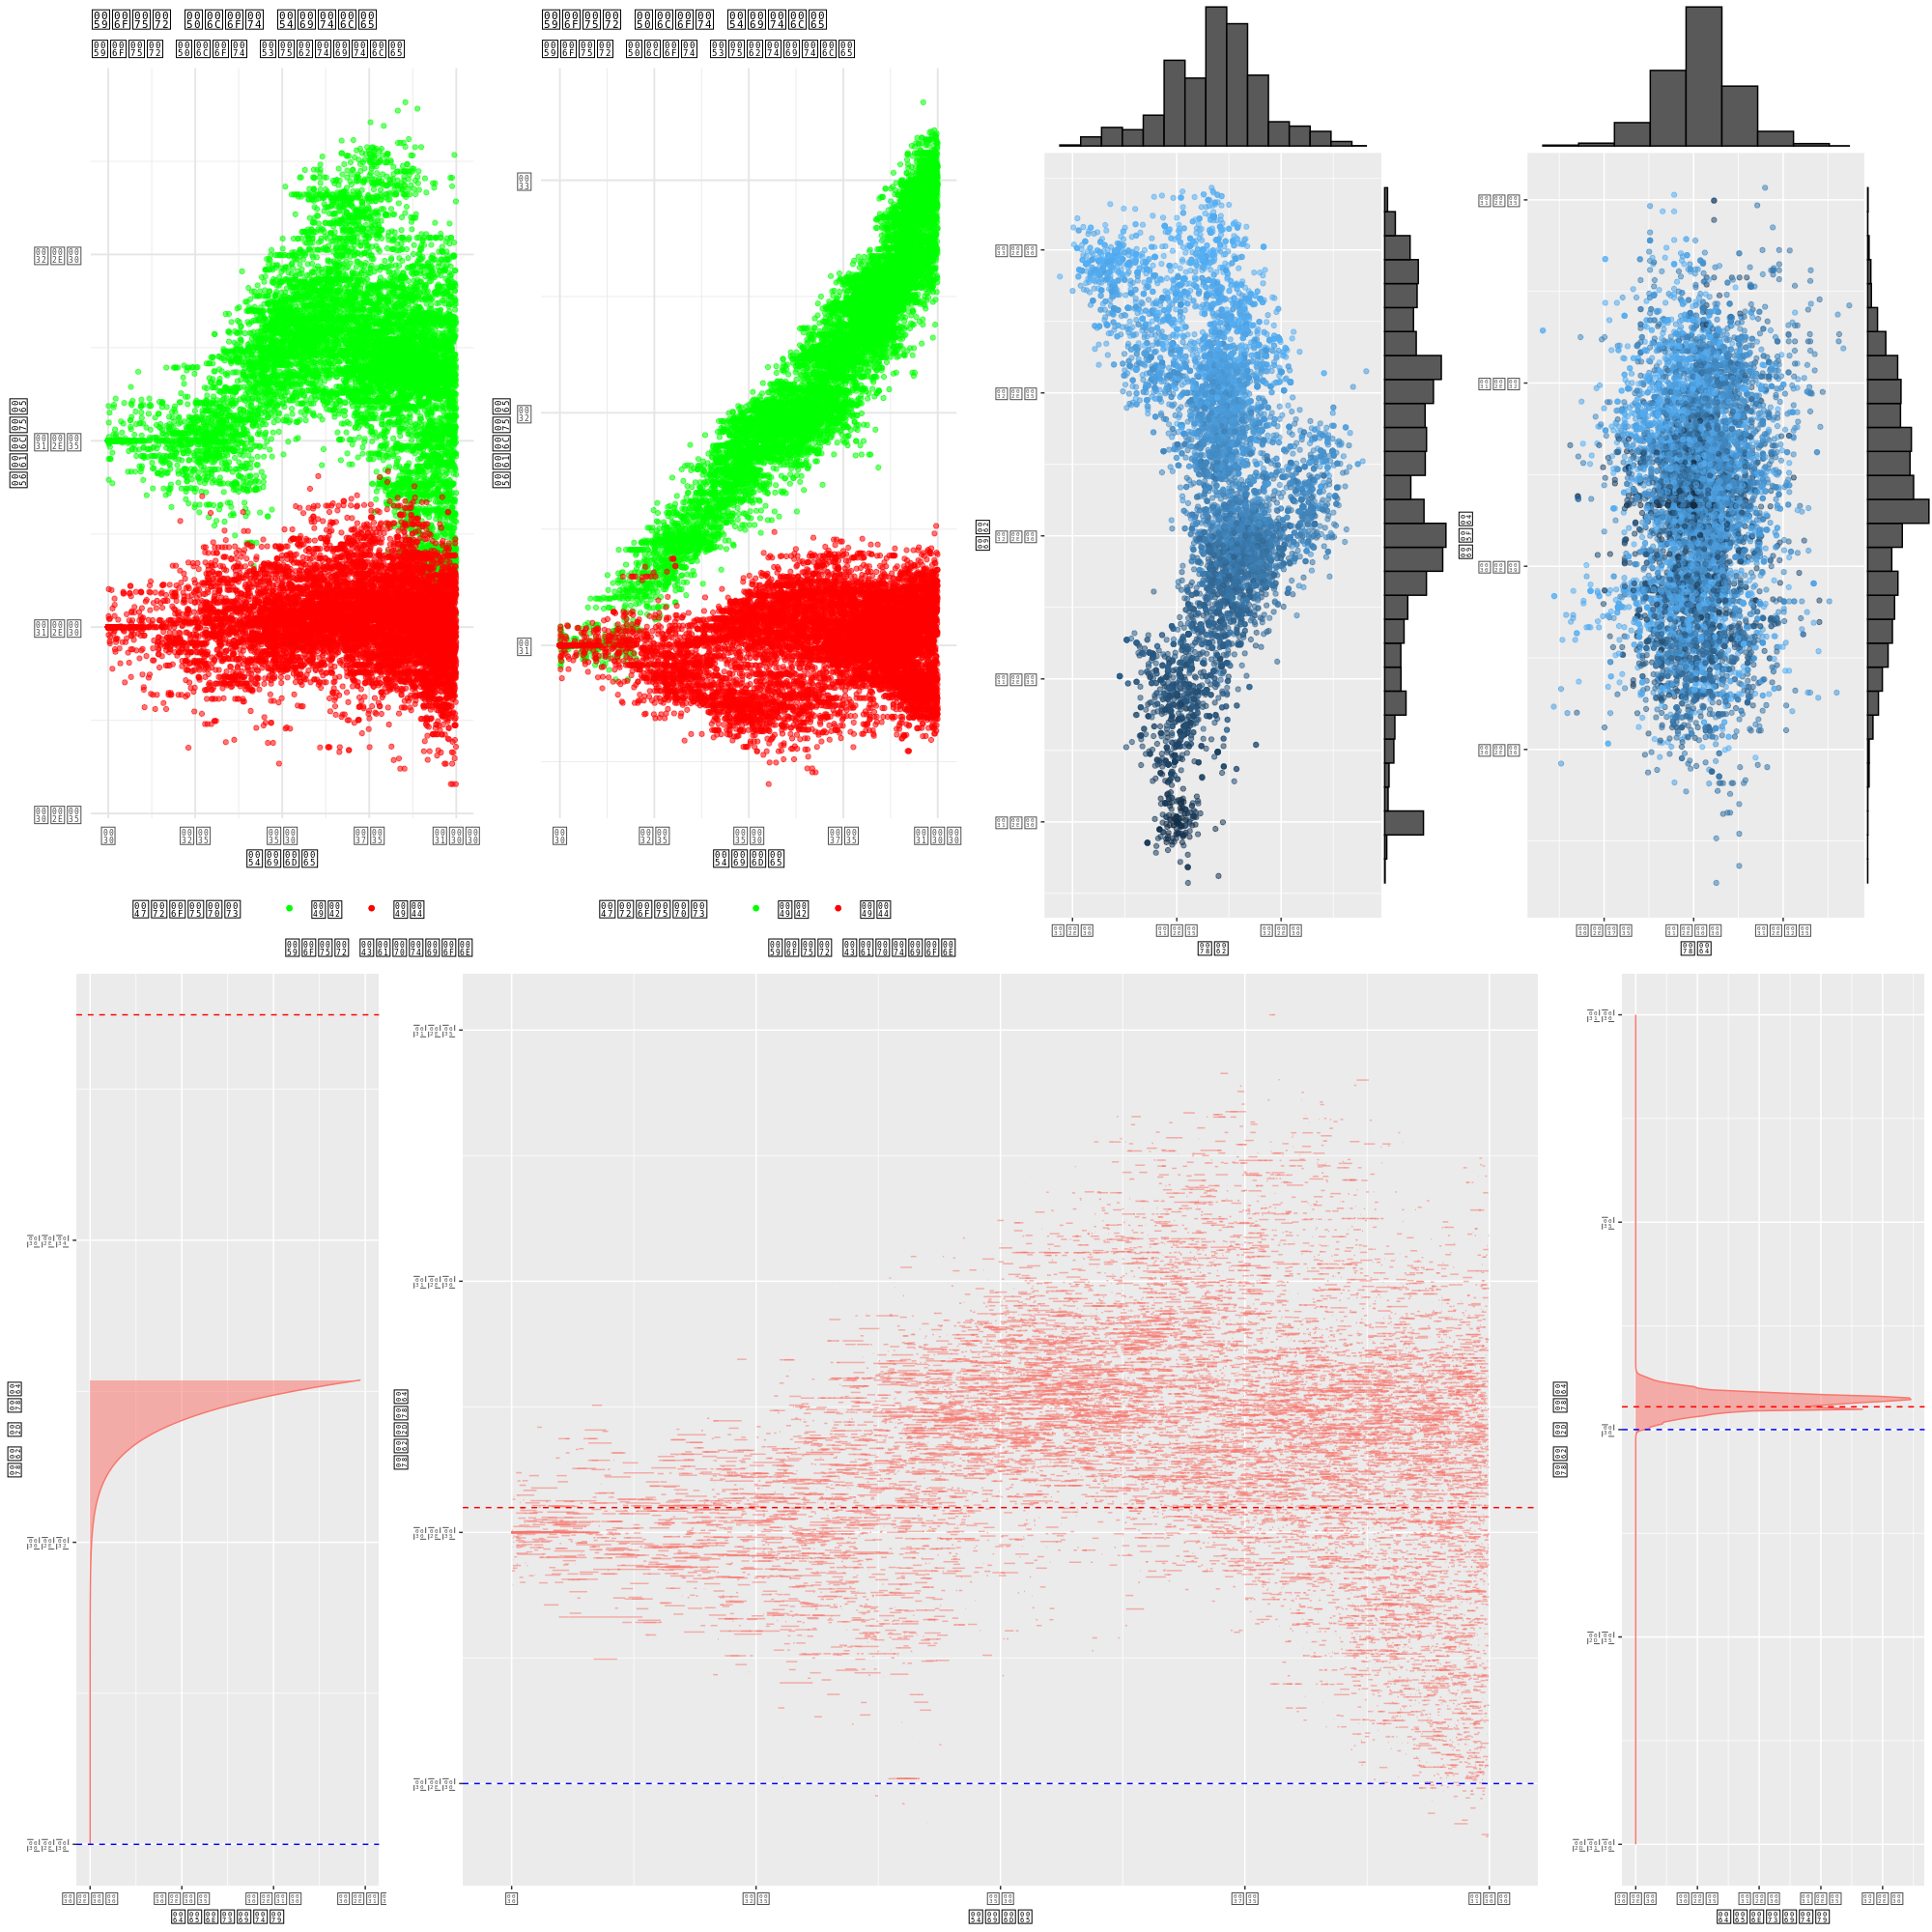

In [64]:
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 100)
layout_matrix <- rbind(
  c(1, 2, 3, 4),
  c(5, 5, 5, 5))
grid.arrange(p0_, p0, p1, p2, p, layout_matrix=layout_matrix)

In [27]:
t=seq(0, round(max(pop_out$birth)))
pop_out_mod <- pop_out %>% mutate(Malthus = ifelse(Lansing==TRUE,malthus_l(xb, xd, x_0, epsilon, delta),malthus_nl(xb, xd, x_0, epsilon, delta)))
fun = function(t){
    pop_t <- population_alive(pop_out_mod, t) 
    pop_t_L <- pop_t %>% filter(Lansing)
    pop_t_nL <- pop_t %>% filter(!Lansing)
    rbind(t, pop_t_L %>% count(), pop_t_L[,7] %>% median(na.rm=TRUE), pop_t_nL%>% count(), pop_t_nL[,7]  %>% median(na.rm=TRUE))
} 
surv_table <- as.data.frame(t(matrix(unlist(cbind(lapply(t, fun))),5)))
colnames(surv_table) <- c("time", "Lansing", "mean_Malthus_L","nonLansing", "mean_Malthus_nL")
max_pop <- surv_table %>% filter(time > 5) %>% select(Lansing, nonLansing) %>% max()
max_pop
head(surv_table)

Warning message in if (b <= d) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while ((abs(H(v, b, d)) > epsilon)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while ((abs(H(v, b, d)) > epsilon)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while ((abs(H(v, b, d)) > epsilon)) {:
“the condition has length > 1 and only the first eleme

In [ ]:
 ggplot(surv_table) + 
  geom_line(aes(x=time, y=Lansing), color = "#00BDD0" )+
  geom_line(aes(x=time, y=nonLansing), color = "#F8766D" ) +
  ylim(0, max_pop)+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

In [ ]:
 ggplot(surv_table) + 
  geom_line(aes(x=time, y=mean_Malthus_L), color = "#00BDD0" )+
  geom_line(aes(x=time, y=mean_Malthus_nL), color = "#F8766D" ) +
  #ylim(0, 1)+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))